In [41]:
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
from collections import defaultdict
import warnings
import time
import matplotlib.pyplot as plt
import matplotlib
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'
from tqdm import tqdm

import alpaca_trade_api as tradeapi

api = tradeapi.REST('PK8FLT5OO4L36N7TIF8P',
                    'Ig3P0MPj2dIOaKxD6AK/MWSGMH94vCi0PbxQxfvN', 
                    'https://paper-api.alpaca.markets')

from datetime import timedelta

matplotlib.rcParams['figure.figsize'] = (8, 5)

In [42]:
def get_data(symbol, lookback):
    all_data = pd.DataFrame()
    for x in range(lookback):
        if x == 0:
            data = api.polygon.historic_agg('minute', 
                                            symbol, 
                                            limit=None).df
        else:
            data = api.polygon.historic_agg('minute', 
                                        symbol, 
                                        _from = (data.index.min() - timedelta(days=5)).strftime('%x %X'),
                                        to = start, 
                                        limit = None).df
        start = data.index.min().strftime('%x %X')
        all_data = pd.concat([data, all_data], axis=0)
    all_data.drop(columns=['volume'], inplace=True)
    all_data.replace(0, method='bfill', inplace=True)
    return all_data
        
def get_stock_data(stocklist, lookback):
    stock_data = {}
    for stock in tqdm(stocklist, desc='Getting stock data'):
        try:
            stock_data[stock] = get_data(stock, lookback)
        except Exception as e:
            print('Exception {} {}'.format(stock, e))
    return stock_data

def resample(stock_data, rate):
    for stock in stock_data:
        stock_data[stock] = stock_data[stock].resample(rate, closed='right', label='right').agg({'open': 'first',
                                                                                                 'high': 'max',
                                                                                                 'low': 'min',
                                                                                                 'close': 'last'}).dropna()
    return stock_data

def get_max_min(prices, smoothing, window_range):
    smooth_prices = prices['close'].rolling(window=smoothing).mean().dropna()
    local_max = argrelextrema(smooth_prices.values, np.greater)[0]
    local_min = argrelextrema(smooth_prices.values, np.less)[0]
    price_local_max_dt = []
    for i in local_max:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_max_dt.append(prices.iloc[i-window_range:i+window_range]['close'].idxmax())
    price_local_min_dt = []
    for i in local_min:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_min_dt.append(prices.iloc[i-window_range:i+window_range]['close'].idxmin())  
    maxima = pd.DataFrame(prices.loc[price_local_max_dt])
    minima = pd.DataFrame(prices.loc[price_local_min_dt])
    max_min = pd.concat([maxima, minima]).sort_index()
    max_min.index.name = 'date'
    max_min = max_min.reset_index()
    max_min = max_min[~max_min.date.duplicated()]
    p = prices.reset_index()   
    max_min['day_num'] = p[p['timestamp'].isin(max_min.date)].index.values
    max_min = max_min.set_index('day_num')['close']
    
    return max_min

def find_patterns(max_min):  
    patterns = defaultdict(list)
    
    for i in range(5, len(max_min)):  
        window = max_min.iloc[i-5:i]
        
        # Pattern must play out in less than n units
        if window.index[-1] - window.index[0] > 100:      
            continue   
            
        a, b, c, d, e = window.iloc[0:5]
                
        # IHS
        if a<b and c<a and c<e and c<d and e<d and abs(b-d)<=np.mean([b,d])*0.02:
               patterns['IHS'].append((window.index[0], window.index[-1]))
        
    return patterns
    
def plot_minmax_patterns(prices, max_min, patterns, stock, window, ema):
    
    incr = str((prices.index[1] - prices.index[0]).seconds/60)
    
    if len(patterns) == 0:
        pass
    else:
        num_pat = len([x for x in patterns.items()][0][1])
        f, axes = plt.subplots(1, 2, figsize=(16, 5))
        axes = axes.flatten()
        prices_ = prices.reset_index()['close']
        axes[0].plot(prices_)
        axes[0].scatter(max_min.index, max_min, s=100, alpha=.3, color='orange')
        axes[1].plot(prices_)
        for name, end_day_nums in patterns.items():
            for i, tup in enumerate(end_day_nums):
                sd = tup[0]
                ed = tup[1]
                axes[1].scatter(max_min.loc[sd:ed].index,
                              max_min.loc[sd:ed].values,
                              s=200, alpha=.3)
                plt.yticks([])
        plt.tight_layout()
        plt.title('{}: {}: EMA {}, Window {} ({} patterns)'.format(stock, incr, ema, window, num_pat))

def get_results(prices, max_min, pat, stock, ema_, window_):
    
    incr = str((prices.index[1] - prices.index[0]).seconds/60)
    
    #fw_list = [1, 12, 24, 36] 
    fw_list = [1, 2, 3]
    results = []
    if len(pat.items()) > 0:
        end_dates = [v for k, v in pat.items()][0]      
        for date in end_dates:  
            param_res = {'stock': stock,
                         'increment': incr,
                         'ema': ema_,
                         'window': window_, 
                         'date': date}
            for x in fw_list:
                returns = (prices['close'].pct_change(x).shift(-x).reset_index(drop=True).dropna())
                try:
                    param_res['fw_ret_{}'.format(x)] = returns.loc[date[1]]   
                except Exception as e:
                    param_res['fw_ret_{}'.format(x)] = e
            results.append(param_res)  
    else:
        param_res = {'stock': stock,
                     'increment': incr,
                     'ema': ema_,
                     'window': window_,
                     'date': None}
        for x in fw_list:
            param_res['fw_ret_{}'.format(x)] = None   
        results.append(param_res)
    return pd.DataFrame(results)

def screener(stock_data, ema_list, window_list, plot, results):
    
    all_results = pd.DataFrame()
    
    for stock in stock_data:
        prices = stock_data[stock]
        
        for ema_ in ema_list:
            for window_ in window_list: 
                max_min = get_max_min(prices, smoothing=ema_, window_range=window_)
                pat = find_patterns(max_min)
                
                if plot == True:
                    plot_minmax_patterns(prices, max_min, pat, stock, window_, ema_)
                    
                if results == True:
                    all_results = pd.concat([all_results, get_results(prices, max_min, pat, stock, ema_, window_)], axis=0)
                
    if results == True:
        return all_results.reset_index(drop=True)

In [43]:
stocklist = ['TWTR', 'MSFT','MMM',
             'S', 'V', 'VZ', 'AAPL', 
             'AMZN', 'FB', 'NFLX', 
             'GOOG', 'GS', 'LNKD',
             'TLRY']

stock_data = get_stock_data(stocklist, 5)

Getting stock data: 100%|██████████████████████████████████████████████████████████████| 14/14 [00:47<00:00,  3.37s/it]


In [44]:
# Run different timeframes here without requesting new data. '5T' = 5 minutes, '60T' = 1 hour, '120T' = 2 hours, etc.
resampled_stock_data = resample(stock_data, '360T')
print(resampled_stock_data)

{'TWTR':                               open    high      low   close
timestamp                                                  
2019-10-18 12:00:00-04:00  39.6000  39.910  38.5100  38.565
2019-10-18 18:00:00-04:00  38.5700  39.090  38.2700  38.950
2019-10-19 00:00:00-04:00  38.9500  38.990  38.9000  38.900
2019-10-21 12:00:00-04:00  39.0501  40.100  39.0500  39.955
2019-10-21 18:00:00-04:00  39.9600  40.290  39.9100  40.100
...                            ...     ...      ...     ...
2019-11-18 11:00:00-05:00  29.3800  29.620  29.0100  29.575
2019-11-18 17:00:00-05:00  29.5700  29.735  29.4105  29.530
2019-11-18 23:00:00-05:00  29.5300  29.590  29.4900  29.530
2019-11-19 05:00:00-05:00  29.5100  29.600  29.5100  29.600
2019-11-19 11:00:00-05:00  29.6700  29.750  29.6000  29.670

[85 rows x 4 columns], 'MSFT':                              open     high     low    close
timestamp                                                  
2019-10-18 06:00:00-04:00  139.64  140.200  139.64  140.100

[83 rows x 4 columns]}


    stock increment  ema  window      date    fw_ret_1   fw_ret_2    fw_ret_3
0    TWTR     360.0    3       3  (19, 27)  0.00233623  0.0026738 -0.00167112
1    TWTR     360.0    3      10      None        None       None        None
2    TWTR     360.0    3      20      None        None       None        None
3    TWTR     360.0    3      30      None        None       None        None
4    TWTR     360.0   10       3      None        None       None        None
..    ...       ...  ...     ...       ...         ...        ...         ...
219  TLRY     360.0   20      30      None        None       None        None
220  TLRY     360.0   30       3      None        None       None        None
221  TLRY     360.0   30      10      None        None       None        None
222  TLRY     360.0   30      20      None        None       None        None
223  TLRY     360.0   30      30      None        None       None        None

[224 rows x 8 columns]


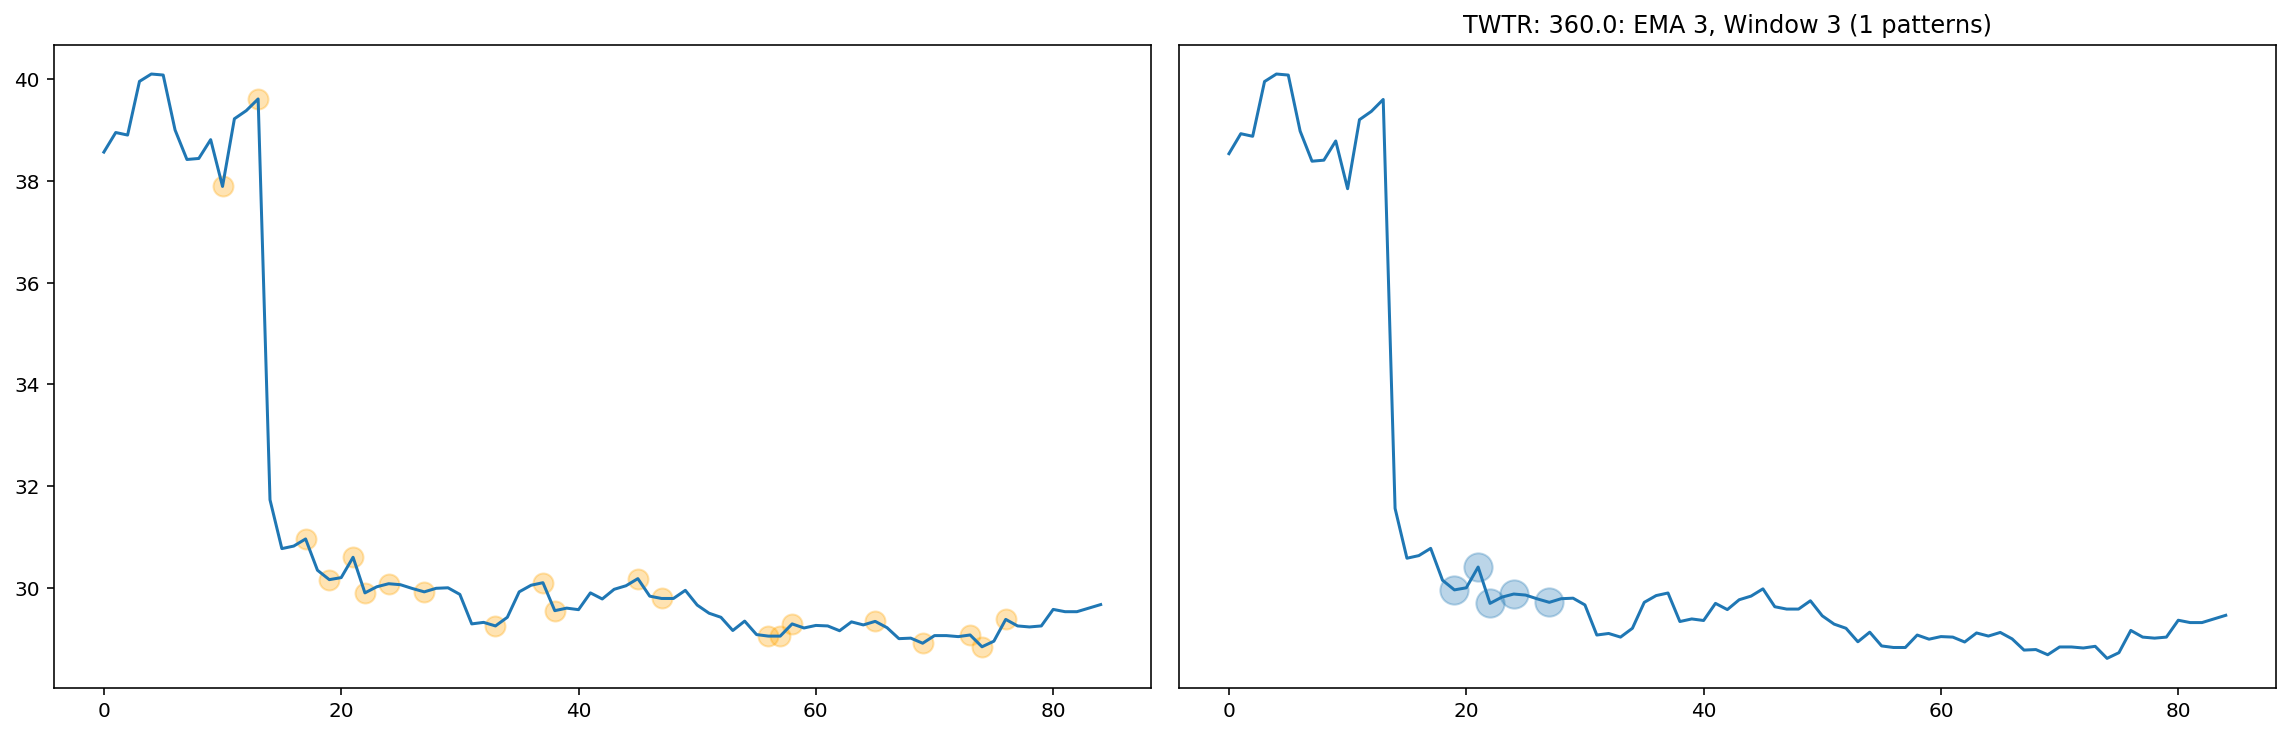

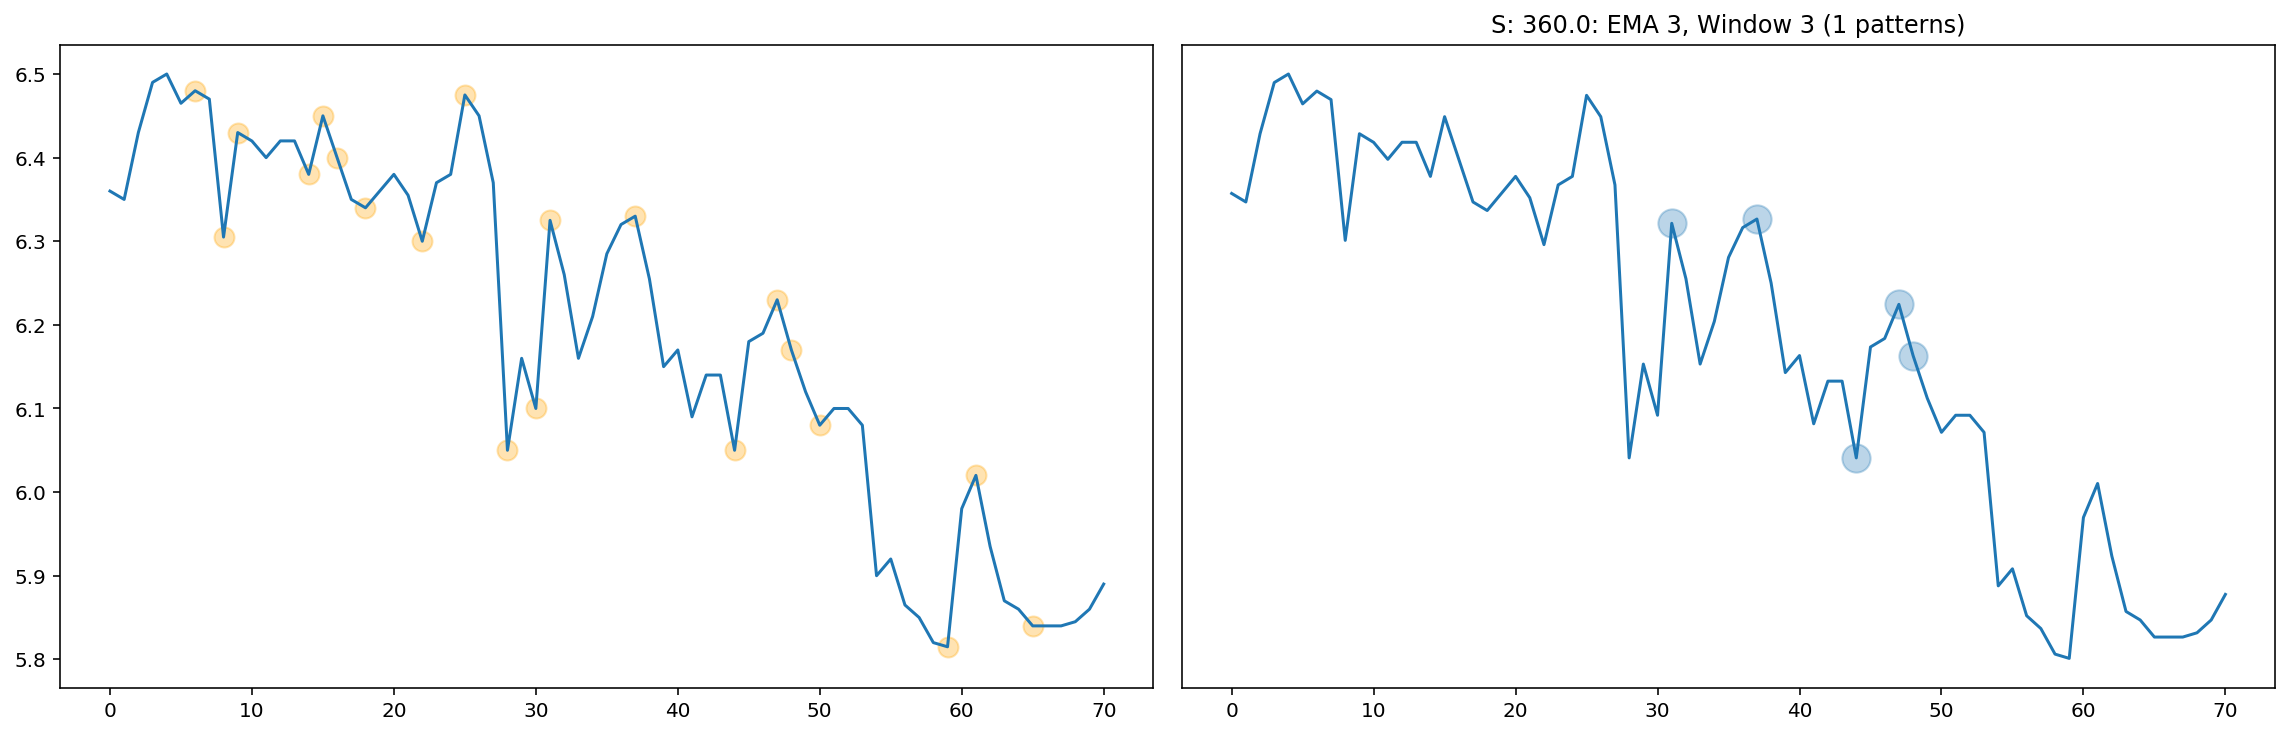

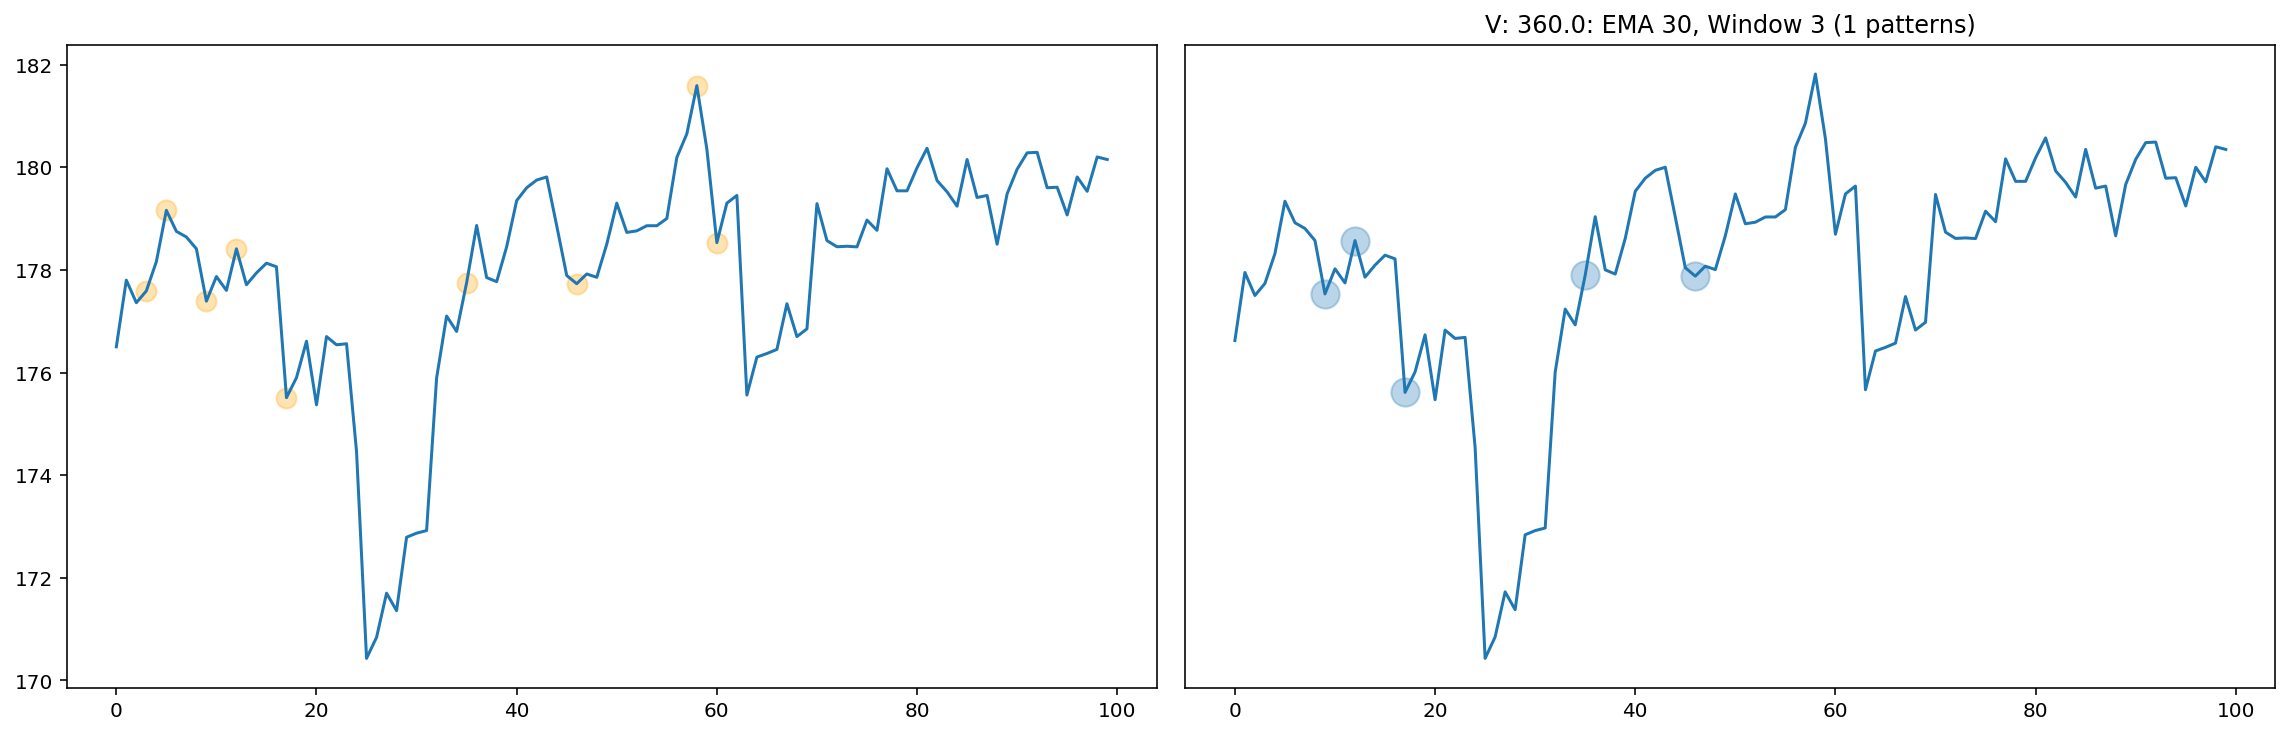

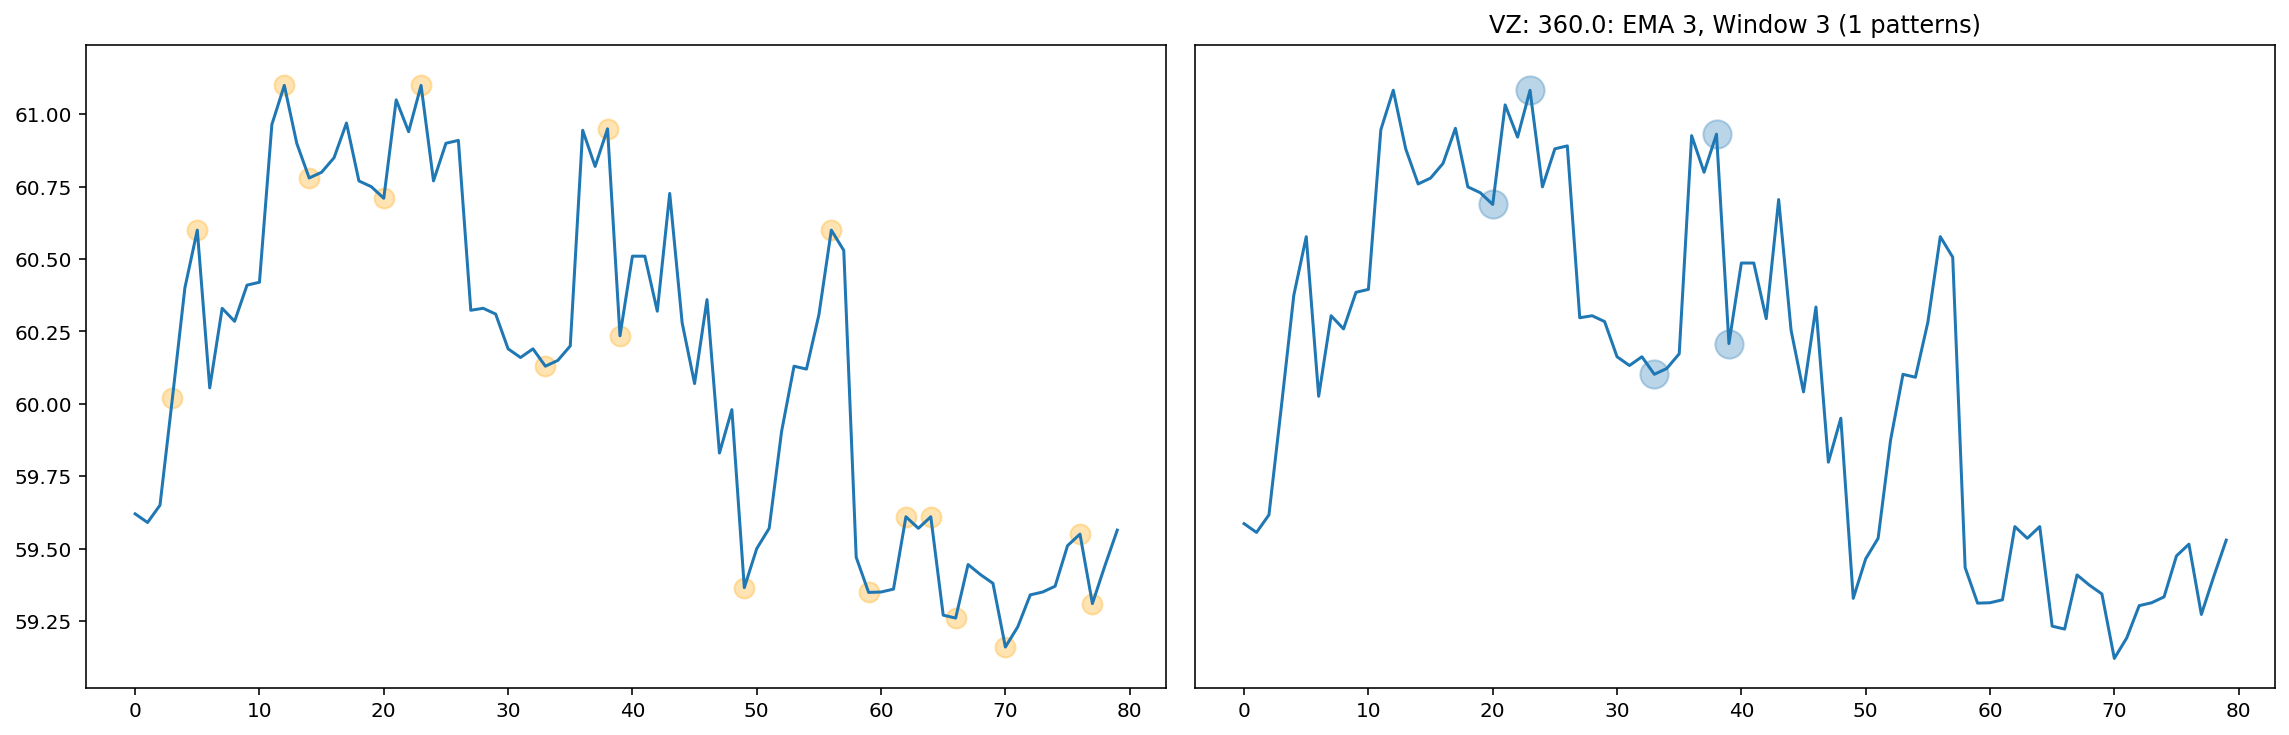

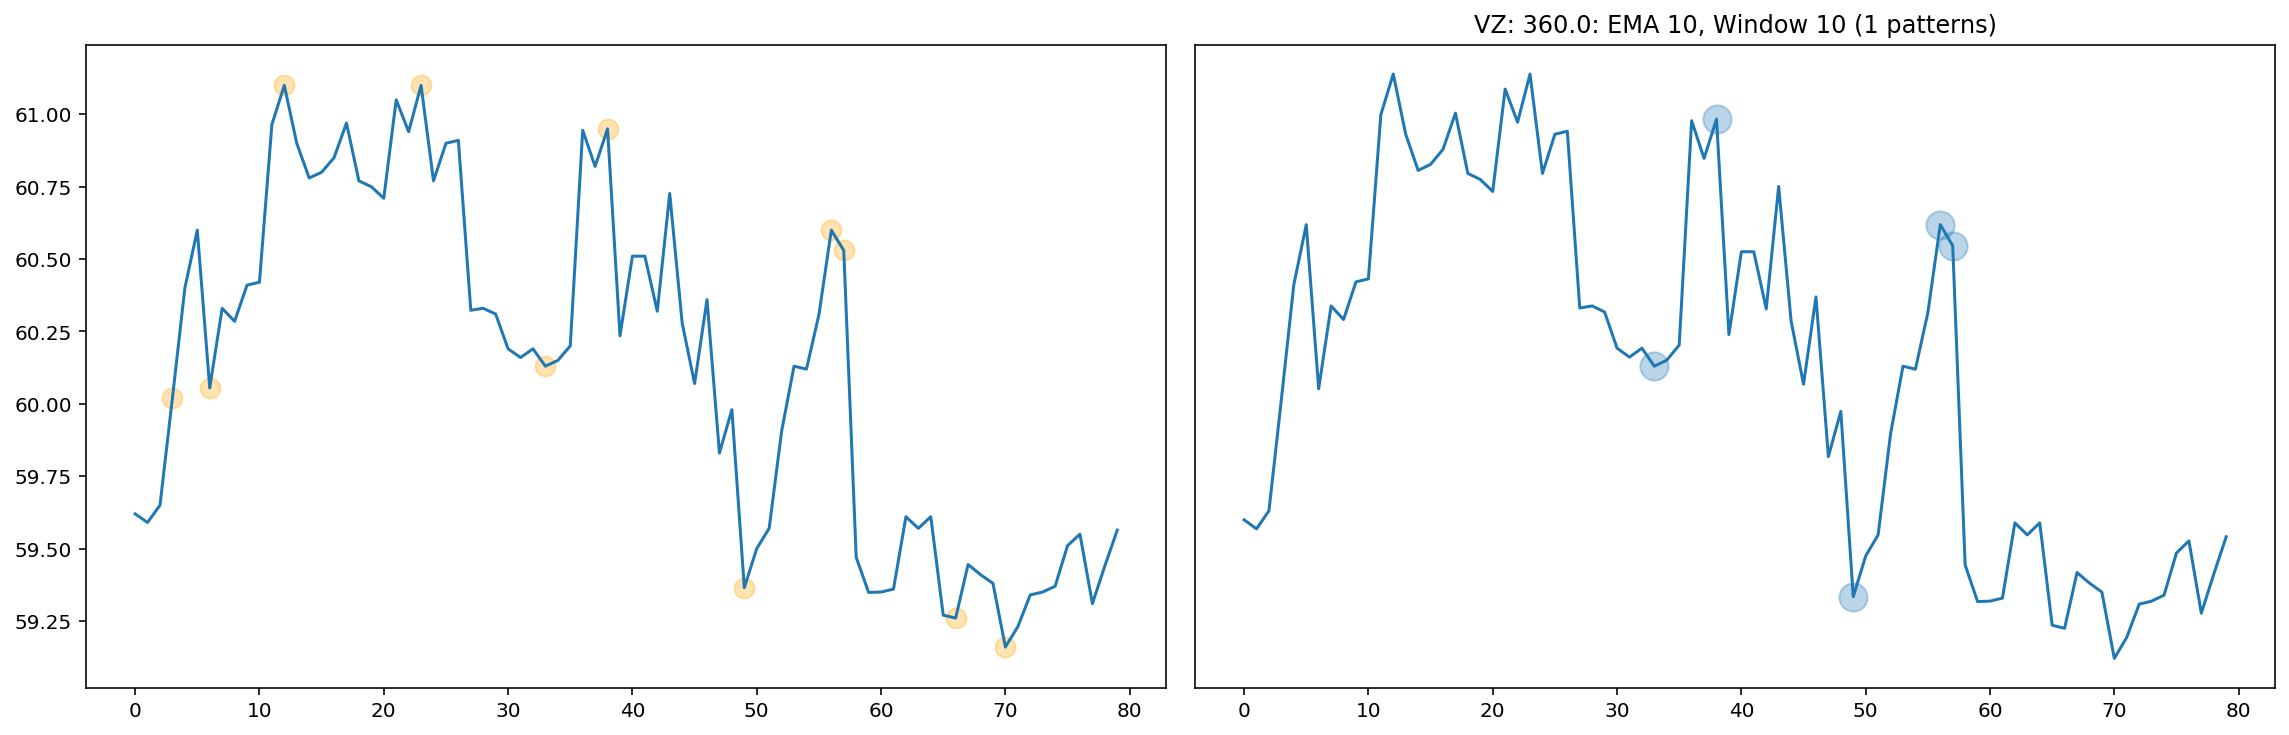

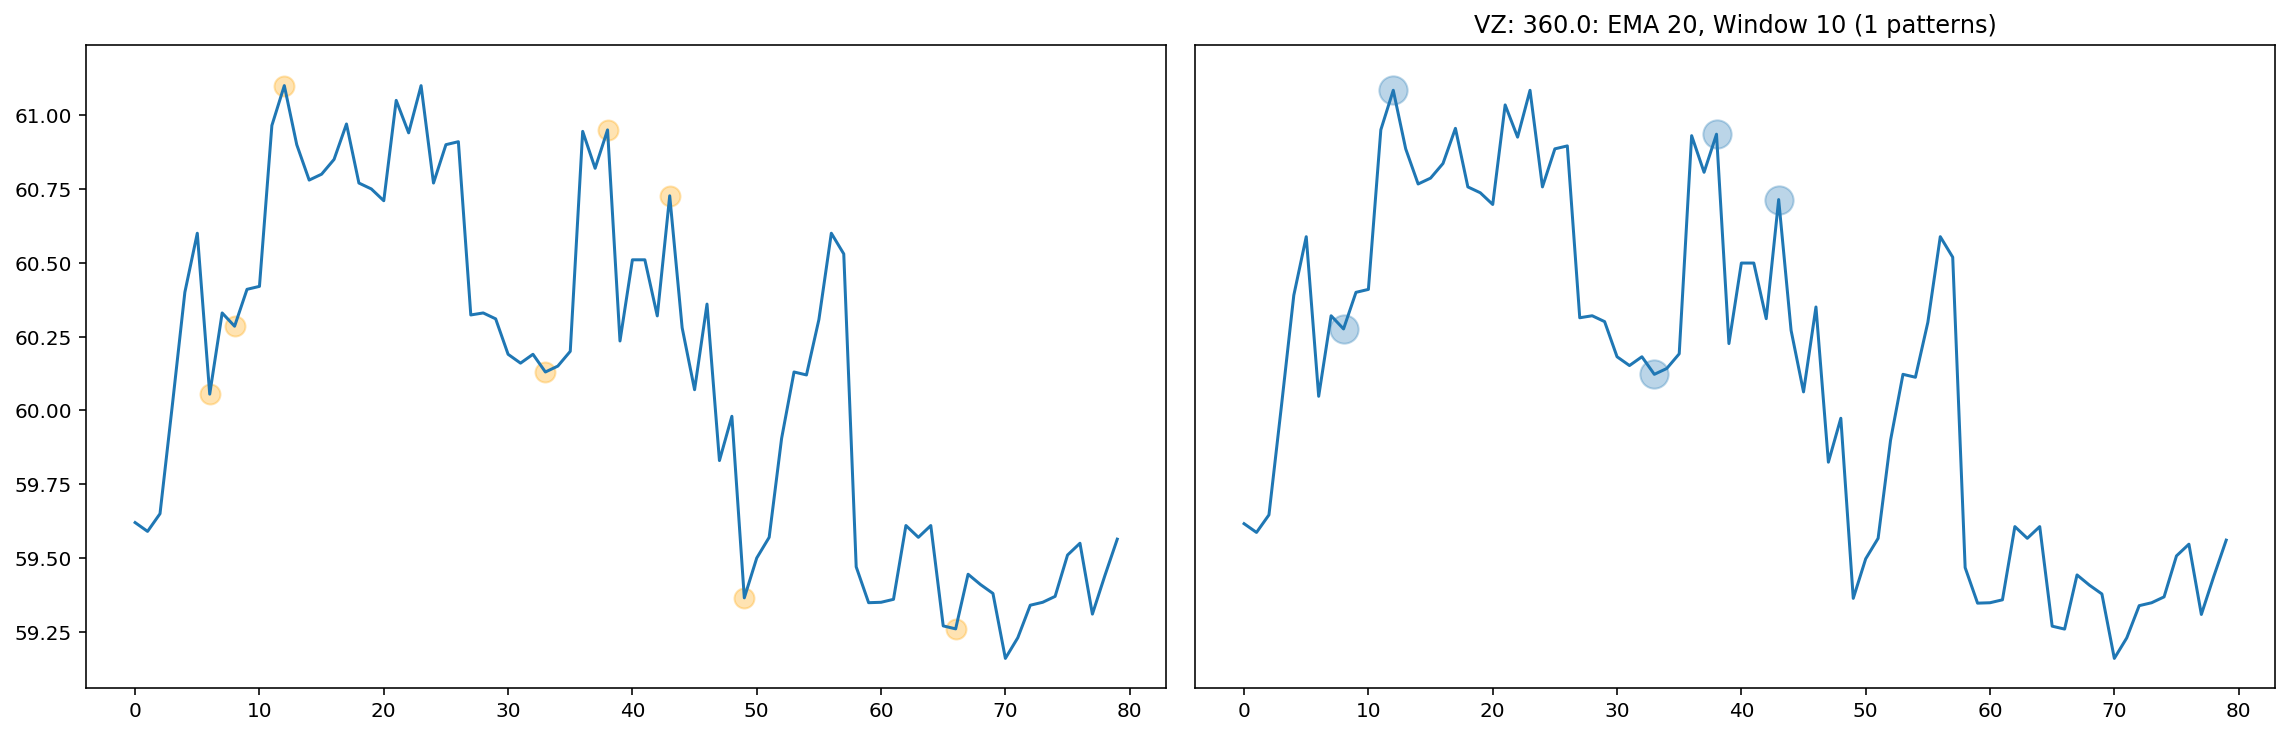

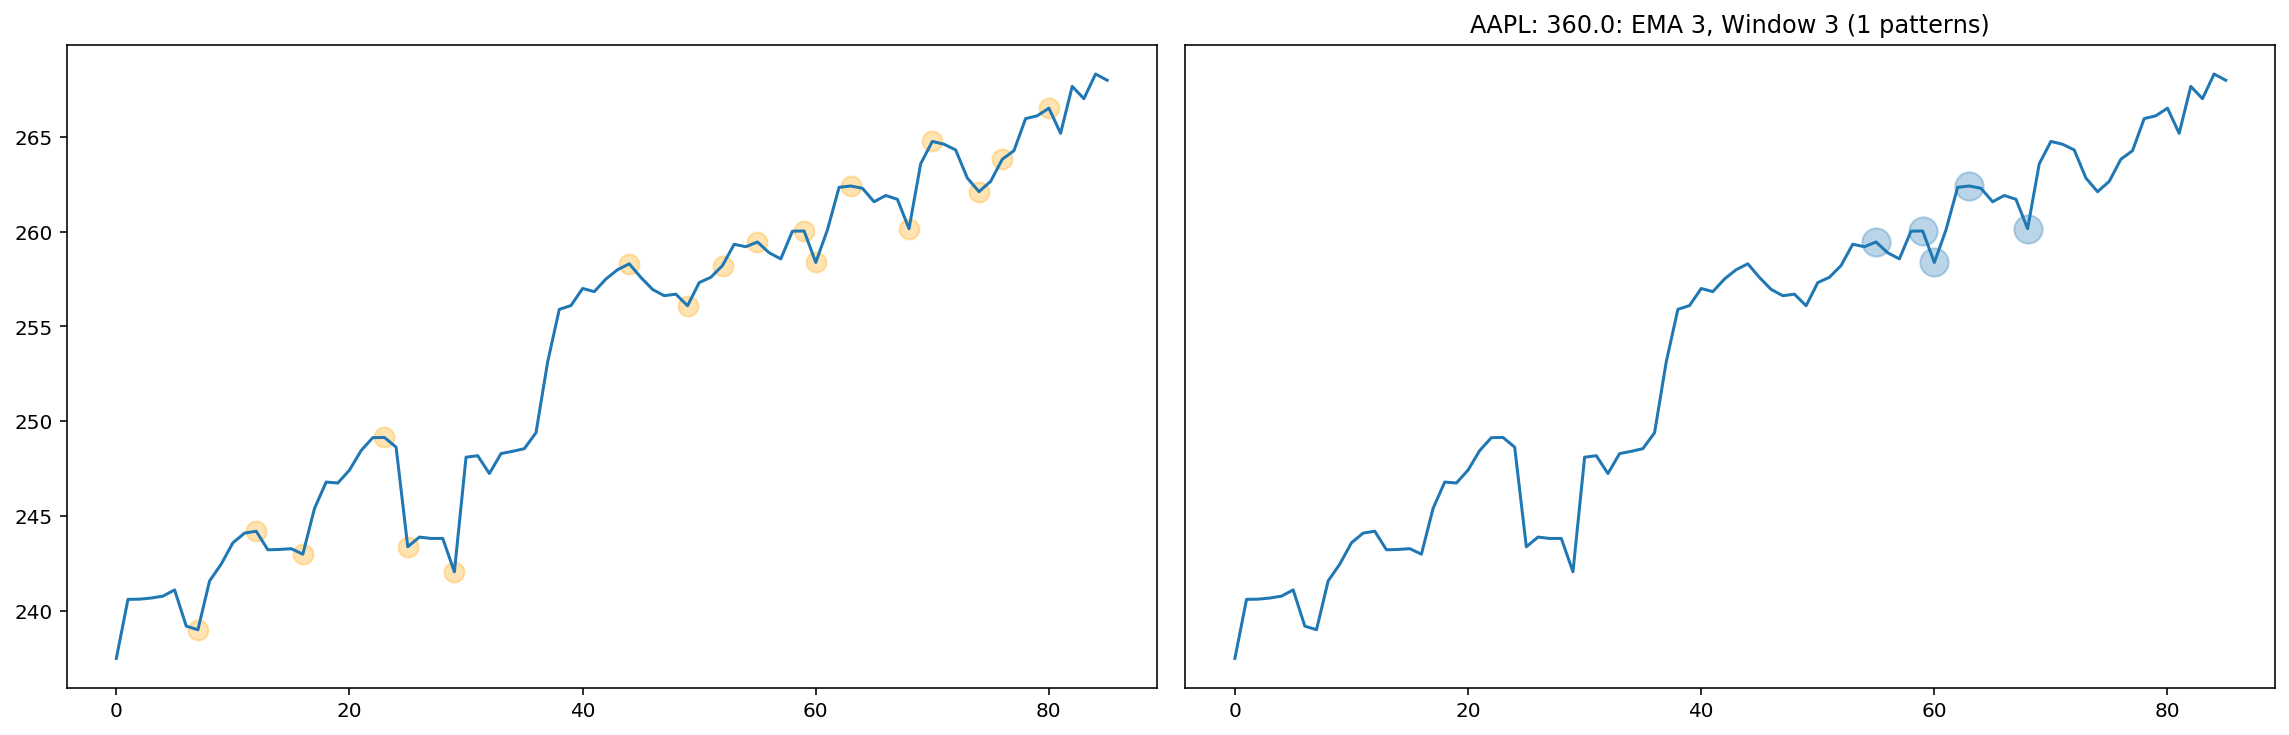

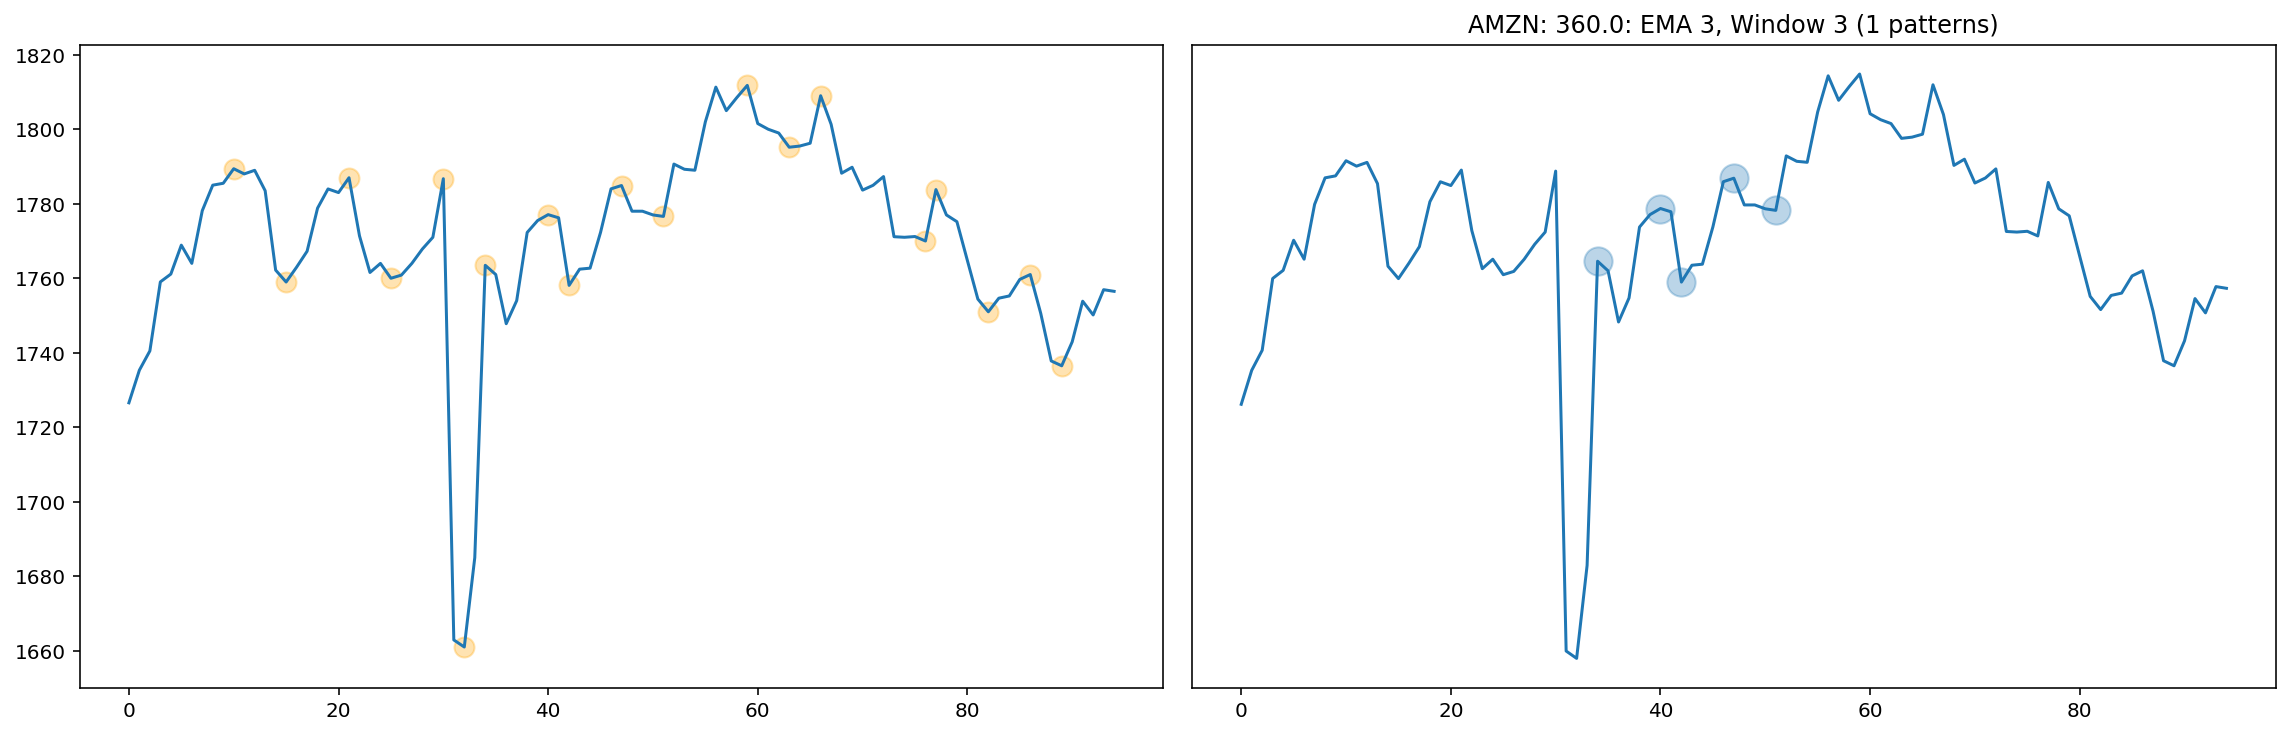

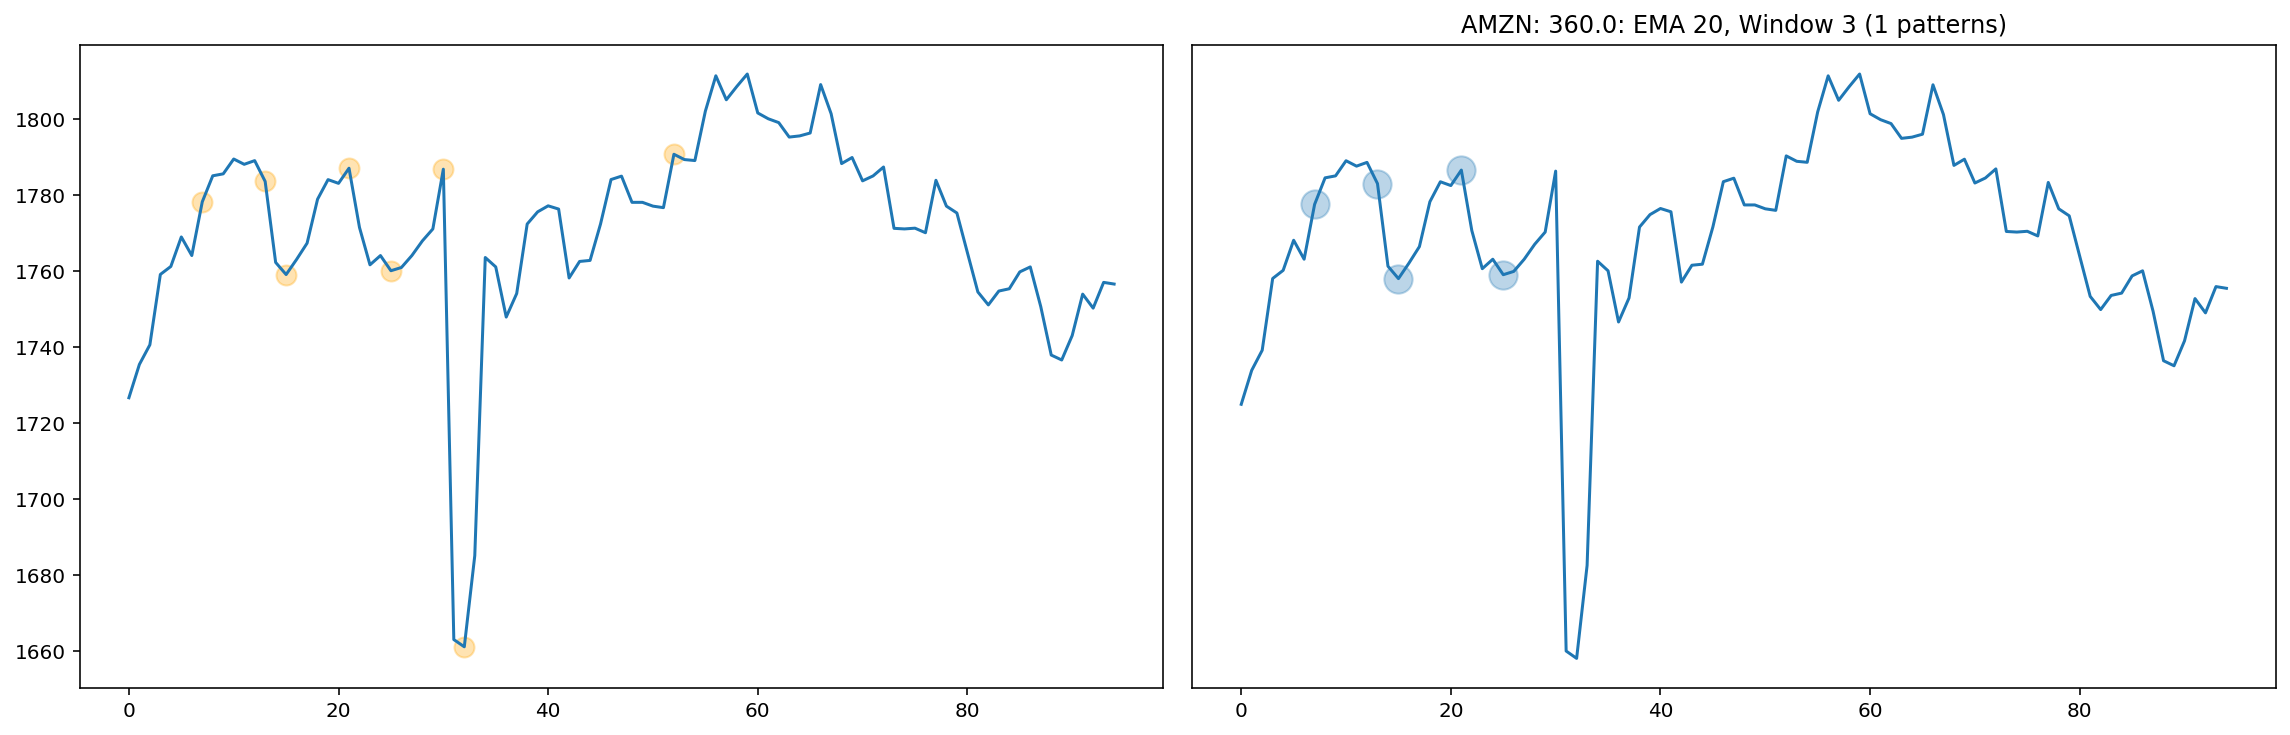

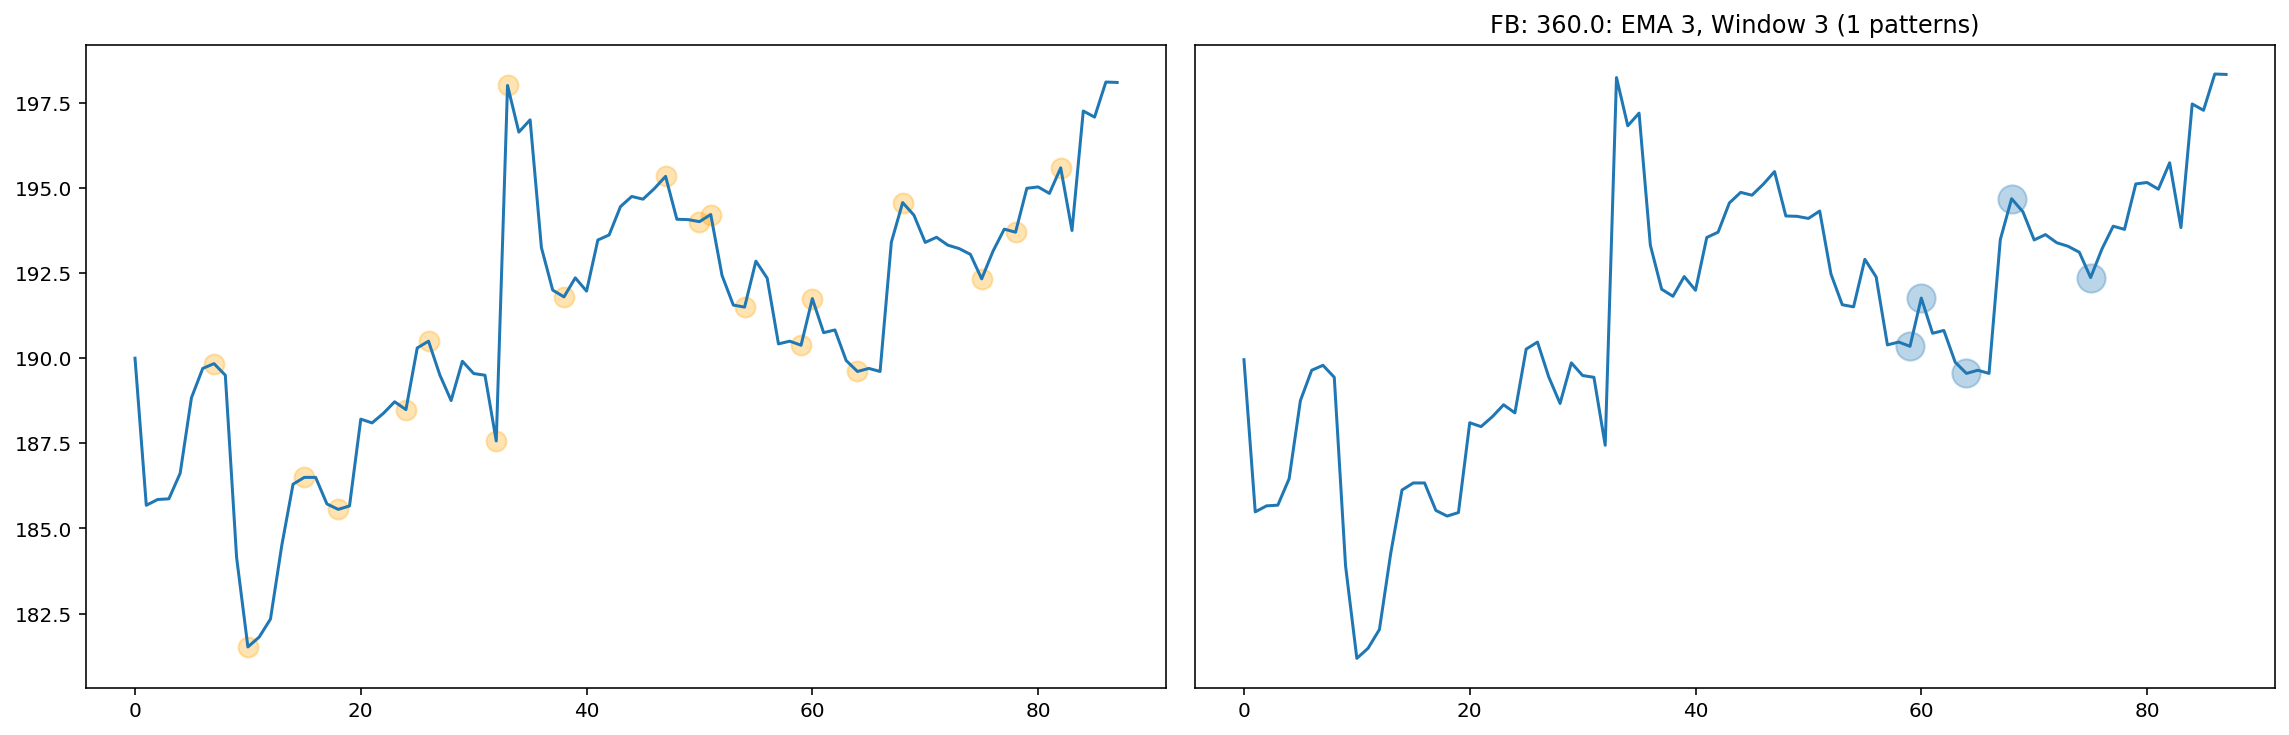

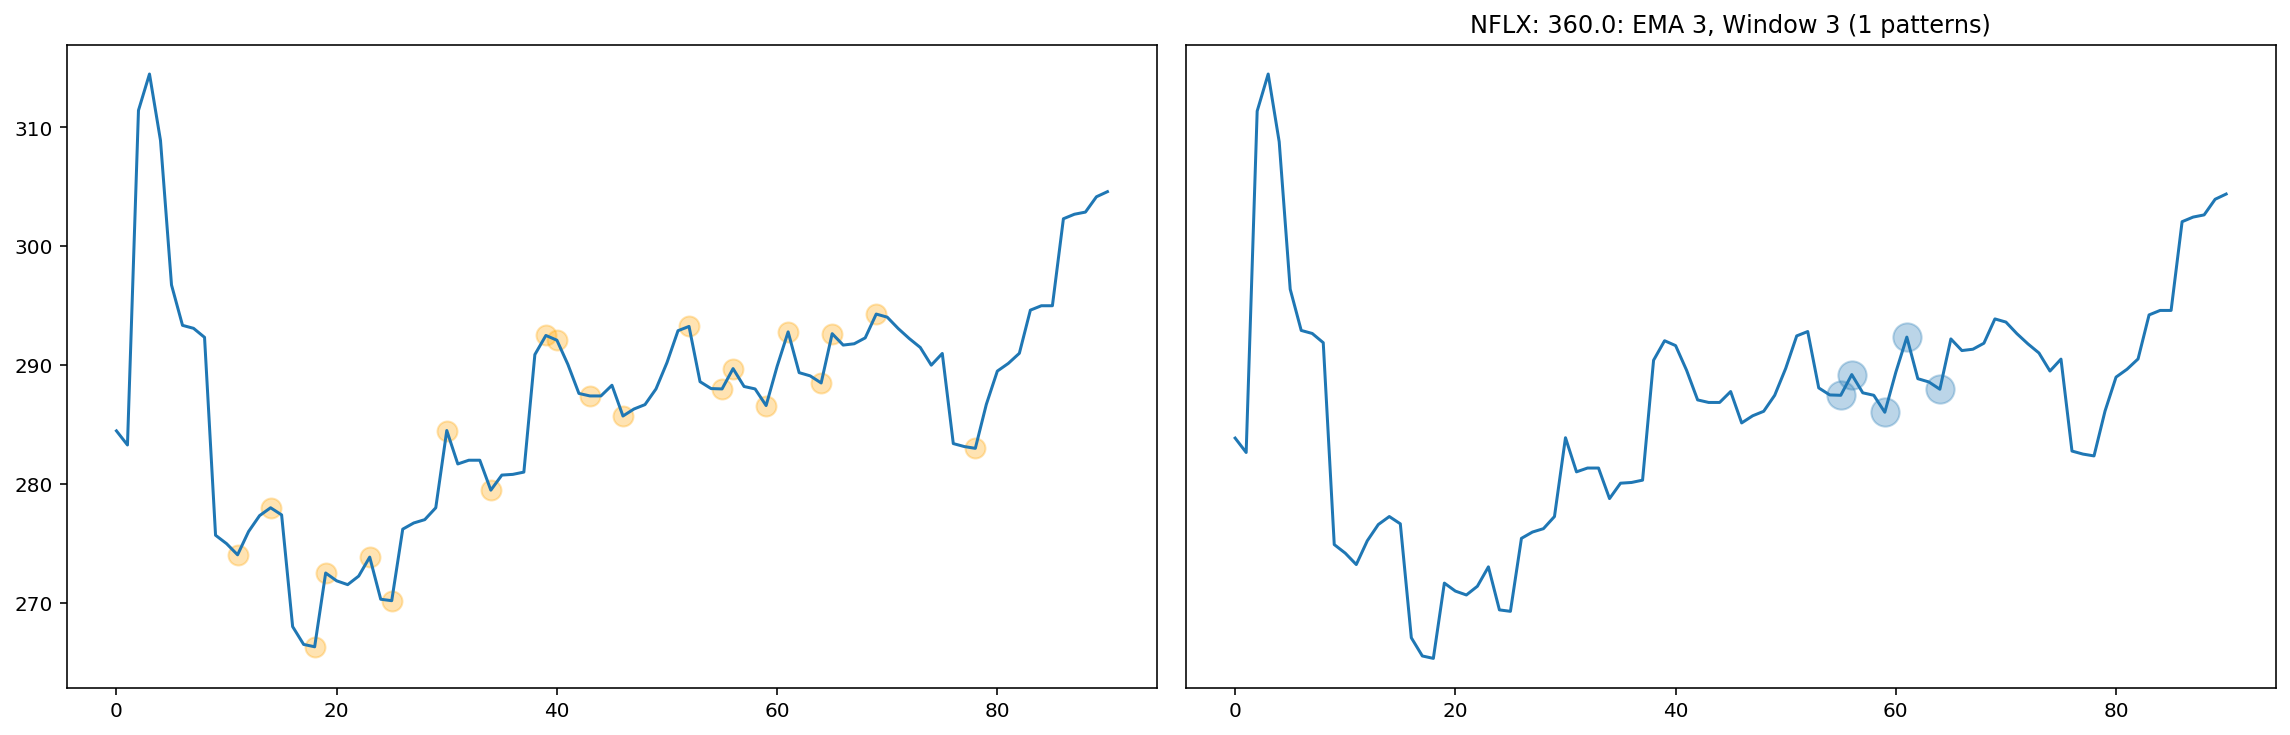

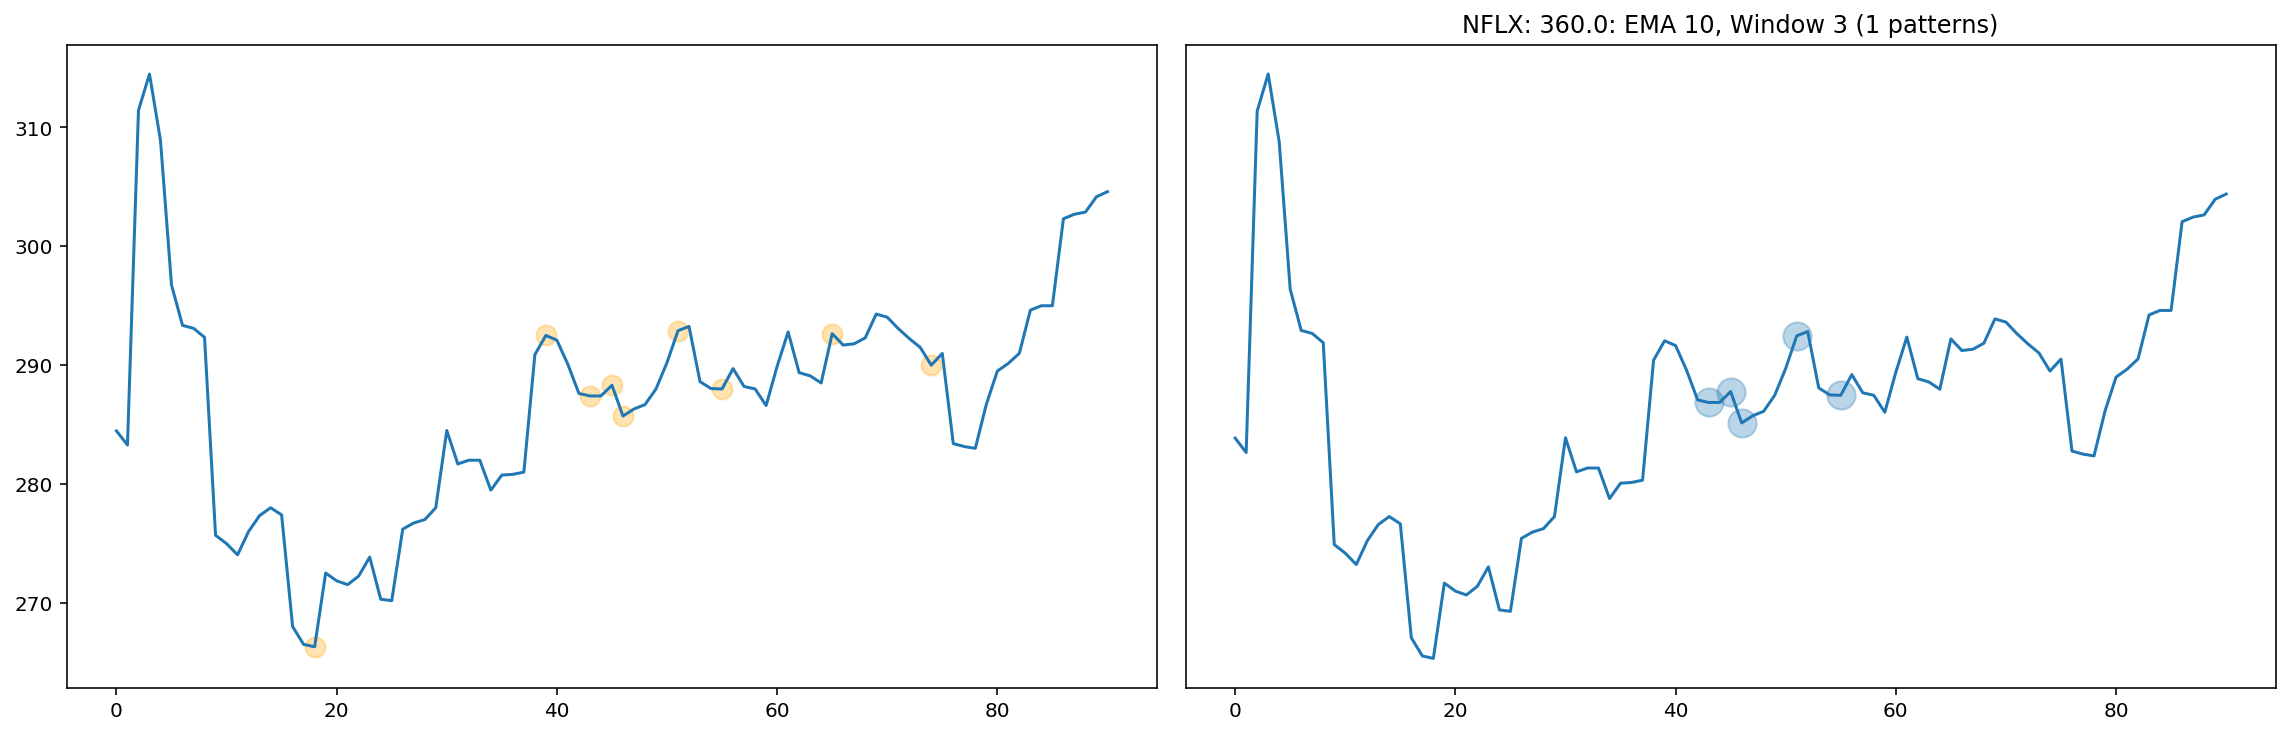

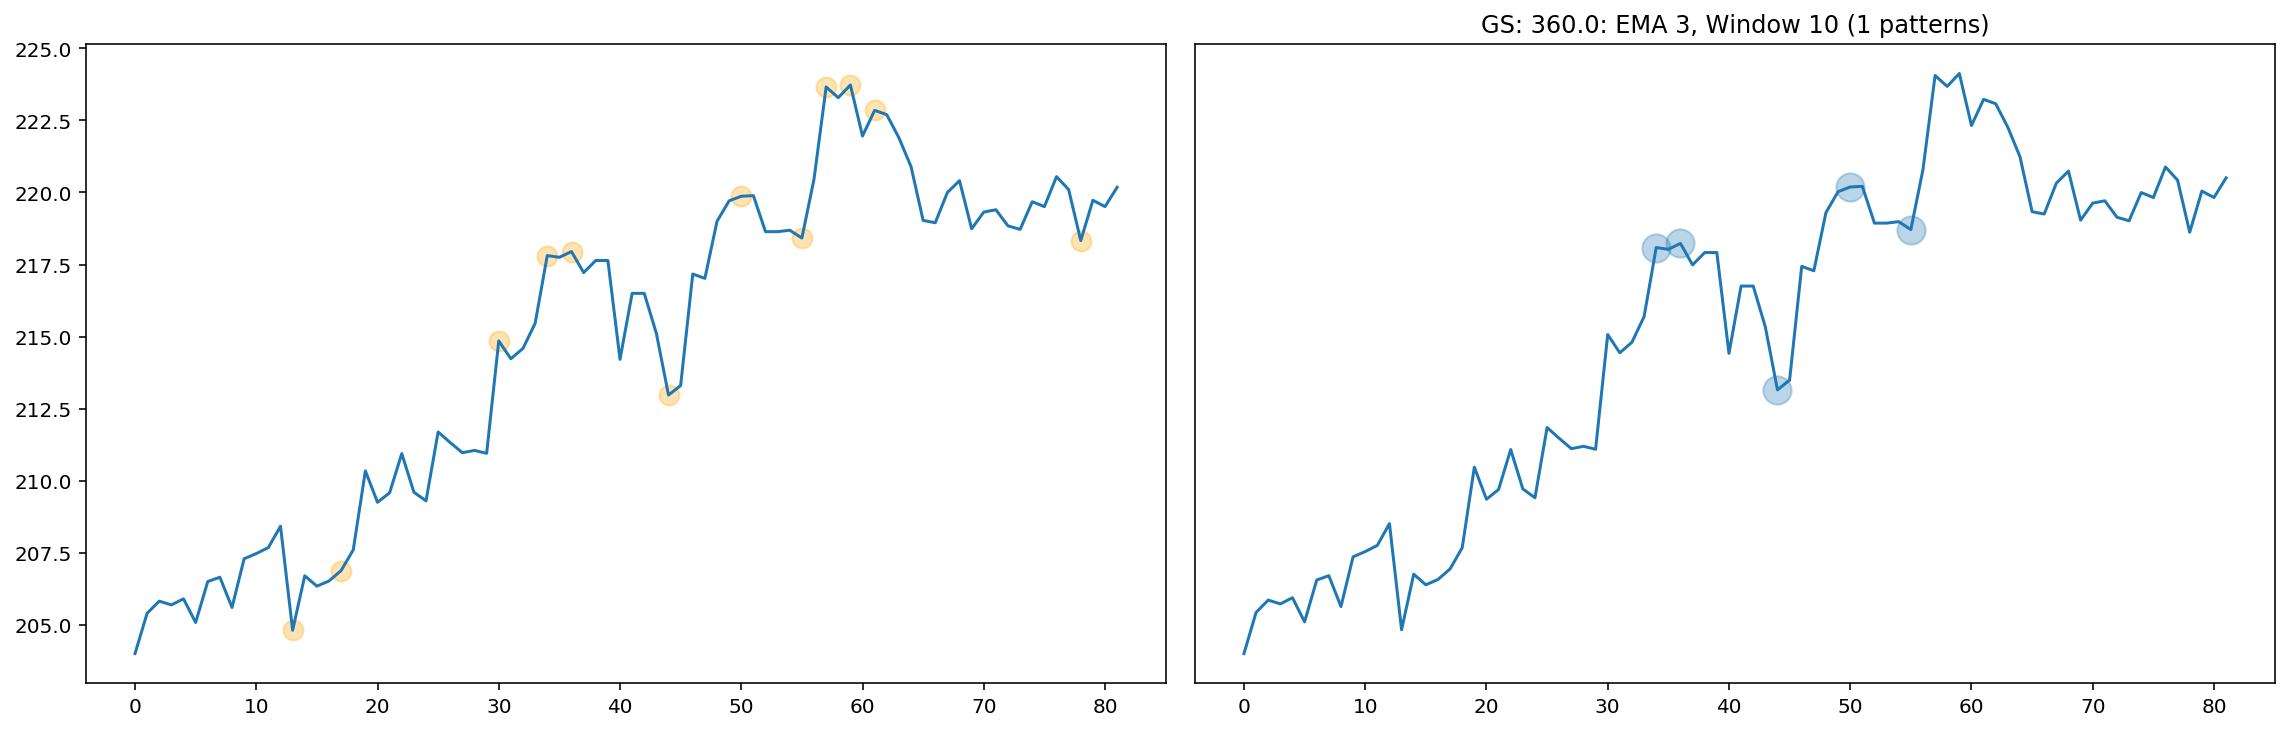

In [45]:
# Run the screener on ema_list and window_list, plotting results.

ema_list = [3, 10, 20, 30, ]
window_list = [3, 10, 20, 30, ]

results = screener(resampled_stock_data, ema_list, window_list, plot=True, results=True)
print(results)

In [48]:
# Examples of reading the results.

for x in [x for x in results.columns if x not in ['stock', 'date']]:
    results[x] = pd.to_numeric(results[x], errors='coerce')
    
print('Average results by window param')
display(round(results.groupby('window').mean(), 3).sort_values(by=[x for x in results.columns if 'fw' in x], ascending=False))
print('\n', 'Average results by ema param')
display(round(results.groupby('ema').mean(), 3).sort_values(by=[x for x in results.columns if 'fw' in x], ascending=False))
print('\n', 'Average results by stock')
display(round(results.groupby('stock').mean(), 3).sort_values(by=[x for x in results.columns if 'fw' in x], ascending=False))
# print('\n', 'Results sorted by return')
# display(round(results.sort_values(by=[x for x in results.columns if 'fw' in x], ascending=False), 3))

Average results by window param


,increment,ema,fw_ret_1,fw_ret_2,fw_ret_3
window,,,,,
3,360.0,15.75,0.005,0.004,0.004
10,360.0,15.75,-0.005,-0.002,-0.001
20,360.0,15.75,NaN,NaN,NaN
30,360.0,15.75,NaN,NaN,NaN



 Average results by ema param


,increment,window,fw_ret_1,fw_ret_2,fw_ret_3
ema,,,,,
3,360.0,15.75,0.006,0.008,0.007
30,360.0,15.75,0.001,0.001,0.004
20,360.0,15.75,-0.003,-0.004,-0.001
10,360.0,15.75,-0.006,-0.009,-0.010



 Average results by stock


,increment,ema,window,fw_ret_1,fw_ret_2,fw_ret_3
stock,,,,,,
AAPL,360.0,15.75,15.75,0.013,0.018,0.017
NFLX,360.0,15.75,15.75,0.010,0.006,0.006
GS,360.0,15.75,15.75,0.009,0.024,0.022
FB,360.0,15.75,15.75,0.004,0.008,0.007
AMZN,360.0,15.75,15.75,0.004,0.005,0.006
TWTR,360.0,15.75,15.75,0.002,0.003,-0.002
V,360.0,15.75,15.75,0.001,0.001,0.004
VZ,360.0,15.75,15.75,-0.007,-0.009,-0.008
S,360.0,15.75,15.75,-0.008,-0.015,-0.011


In [47]:
# Saves to .csv for later
# results.to_csv('./tech_patterns_results_7.csv')